In [47]:
import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [48]:
# get all the image paths
image_paths = list(paths.list_images('input/Images'))
# create an empty DataFrame
data = pd.DataFrame()
labels = []
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
    
labels = np.array(labels)
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping an one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    #index = labels[i]

    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
# save as csv file
data.to_csv('input/data.csv', index=False)
# pickle the label binarizer
joblib.dump(lb, 'output/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')
print(data.head())

100%|██████████| 656/656 [00:00<00:00, 6727.23it/s]

The first one hot encoded labels: [1 0 0 0 0 0 0 0 0 0 0]
Mapping an one hot encoded label to its category: cbf
Total instances: 656
Save the one-hot encoded binarized labels as a pickled file.
                      image_path  target
0   input/Images\cmbf\cmbf_1.jpg     3.0
1  input/Images\cmcf\cmcf_16.jpg     4.0
2    input/Images\ccf\ccf_41.jpg     1.0
3  input/Images\omff\omff_36.jpg    10.0
4   input/Images\ombf\ombf_5.jpg     8.0


In [49]:
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [50]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cpu


In [51]:
# construct the argument parser and parse the arguments
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', default=50, type=int,
    help='number of epochs to train the model for')
#args = vars(parser.parse_args())
args, unknown = parser.parse_known_args()
args = vars(args)

In [52]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('input/data.csv')
X = df.image_path.values
y = df.target.values

In [53]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))


In [54]:
# image dataset module
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True),
                albumentations.Normalize(mean=[0, 0, 0],
                          std=[1, 1, 1], always_apply=True)
                #albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                #          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
            '''
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True)
            ])
            '''
        else: # if training
            
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True),
                albumentations.Normalize(mean=[0, 0, 0],
                          std=[1, 1, 1], always_apply=True)
                #albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                #          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
            '''
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True)
            ])
            '''
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

Feature Batch Shape: torch.Size([16, 3, 72, 72])
Label Batch Shape: torch.Size([16])


<ipython-input-54-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


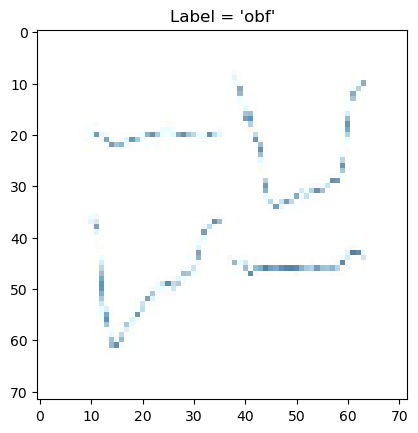

Labels: [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [55]:
vows = ['cbf', 'ccf', 'cff', 'cmbf', 'cmcf', 'cmff', 'obf', 'off', 'ombf', 'omcf', 'omff']

train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
test_data = NaturalImageDataset(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

trainfeature, trainlabel = next(iter(trainloader))
print(f"Feature Batch Shape: {trainfeature.size()}")
print(f"Label Batch Shape: {trainlabel.size()}")
imgdir = np.transpose(trainfeature[0].squeeze(), (1,2,0))
plt.imshow(imgdir, cmap="gray")
plt.title("Label = '{}'".format(vows[np.array(trainlabel)[0]]))
plt.show()
print(f"Labels: {labels}")

In [56]:
# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('output/lb.pkl')

Loading label binarizer...


In [57]:
def model(pretrained, requires_grad):
    model = models.vgg16(progress=True, pretrained=pretrained)

    
    
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1000, len(lb.classes_))
    )
    return model
model = model(pretrained=True, requires_grad=True).to(device)
print(model)

c:\Users\ikeryu\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ikeryu\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

learning rate=1e-4, momentum=0.9, weight decay=0.0005, 
batch size = 16, epoch = 50 
criterion = Cross Entropy Loss

In [59]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [60]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [61]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(args['epochs']):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 50
Training


  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-54-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)
31it [00:31,  1.03s/it]                        


Train Loss: 0.3252, Train Acc: 13.21
Validating


11it [00:02,  5.50it/s]                        


Val Loss: 0.2340, Val Acc: 29.27
Epoch 2 of 50
Training


31it [00:32,  1.06s/it]                        


Train Loss: 0.1693, Train Acc: 25.81
Validating


11it [00:02,  5.23it/s]                        


Val Loss: 0.1188, Val Acc: 41.46
Epoch 3 of 50
Training


31it [00:32,  1.03s/it]                        


Train Loss: 0.1062, Train Acc: 40.24
Validating


11it [00:02,  5.44it/s]                        


Val Loss: 0.1164, Val Acc: 35.98
Epoch 4 of 50
Training


 10%|█         | 3/30 [00:03<00:29,  1.10s/it]

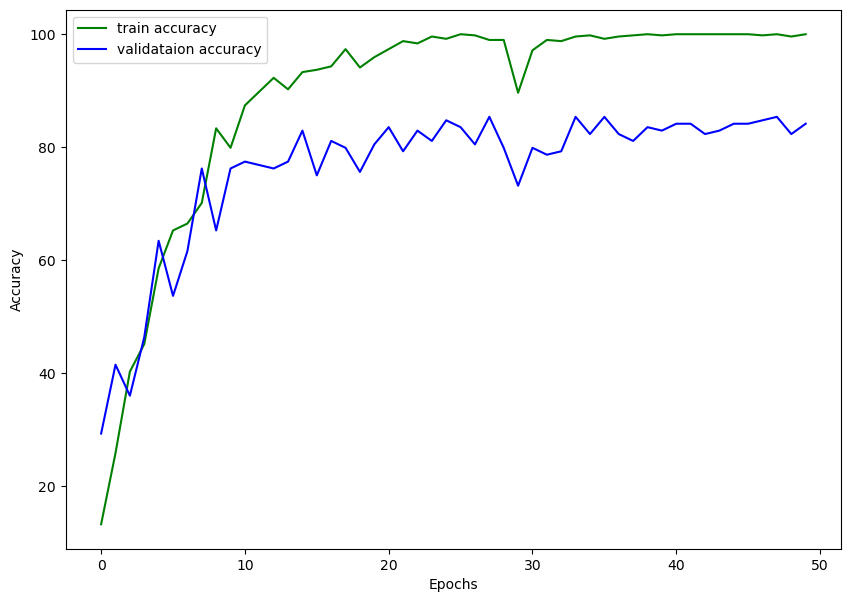

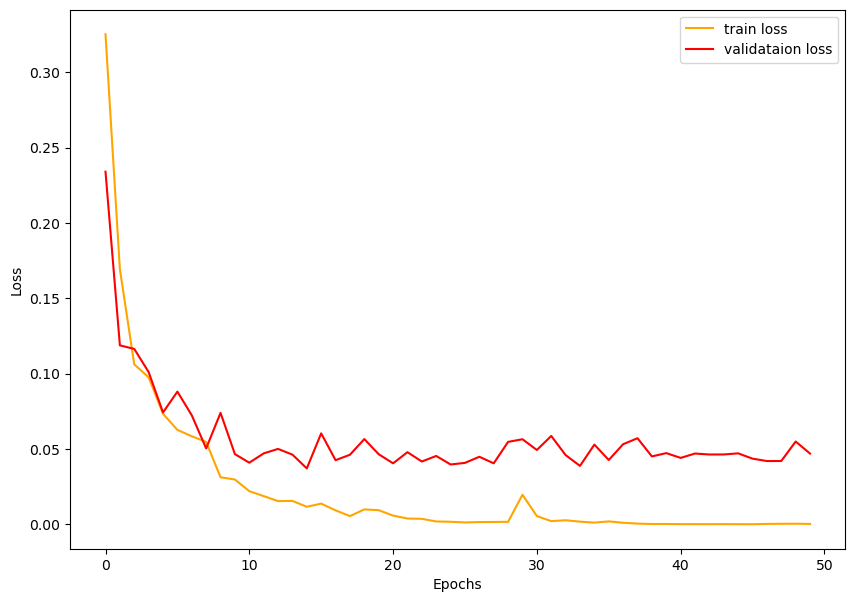

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_vgg_dropout.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_vgg_dropout.jpg')
plt.show()

In [ ]:
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(class_correct)
print(class_total)
print(sum(class_correct)/sum(class_total))
for i in range(11):
    print('Accuracy of %5s : %2d %%' % (
        vows[i], 100 * class_correct[i] / class_total[i]))

<ipython-input-35-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


[16.0, 11.0, 7.0, 14.0, 12.0, 9.0, 16.0, 13.0, 11.0, 11.0, 18.0]
[17.0, 14.0, 7.0, 15.0, 22.0, 12.0, 18.0, 13.0, 12.0, 15.0, 19.0]
0.8414634146341463
Accuracy of   cbf : 94 %
Accuracy of   ccf : 78 %
Accuracy of   cff : 100 %
Accuracy of  cmbf : 93 %
Accuracy of  cmcf : 54 %
Accuracy of  cmff : 75 %
Accuracy of   obf : 88 %
Accuracy of   off : 100 %
Accuracy of  ombf : 91 %
Accuracy of  omcf : 73 %
Accuracy of  omff : 94 %
